# Strings support in cuDF

In [1]:
import seaborn as sns

NV_COLORS = ["#6FAE00", "#008564", "#5D1682", "#0C34BD", "#4A4A4A"]
sns.set_palette(sns.color_palette(NV_COLORS))

## Example 1 - redaction

https://developer.nvidia.com/blog/mastering-string-transformations-in-rapids-libcudf/

In [2]:
import rmm
rmm.reinitialize(pool_allocator=True)

In [3]:
import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [333]:
def make_names(N, lib):
    data = cudf.datasets.randomdata(N, {'first_name': str, 'last_name': str})
    data['name'] = data['first_name'] + " " + data['last_name']
    data = data[['name']]
    visibility = lib.Series(['private', 'public'])
    visibility = visibility.sample(N, replace=True).reset_index(drop=True)
    data['visibility'] = visibility
    if lib == cudf:
        return data
    else:
        return data.to_pandas()

def shorten_names(first_names, last_names):
    last_initial = last_names.str.get(0)
    return last_initial + " " + first_names

def redact(data):
    first_and_last = data['name'].str.split(expand=True)
    first, last = first_and_last[0], first_and_last[1]
    shortened = shorten_names(first, last)
    redacted = shortened.where(data['visibility'] == 'public', "X X")
    return redacted

In [334]:
cudf_data = make_names(5_000_000, cudf)
pandas_data = make_names(5_000_000, pd)

In [372]:
sizes = pd.Series([0.6, 1, 2, 5, 6, 8, 10]) * 1_000_000
result = pd.DataFrame(columns=['size', 'lib', 'time'])

for s in sizes:
    cudf_data = make_names(int(s), cudf)
    pd_data = make_names(int(s), pd)
    cudf_result = %timeit -o redact(cudf_data)
    pd_result = %timeit -o redact(pd_data)
    result = pd.concat([result, pd.DataFrame({'size': [s], 'lib': 'cudf', 'time': cudf_result.best})])
    result = pd.concat([result, pd.DataFrame({'size': [s], 'lib': 'pandas', 'time': pd_result.best})])

3.52 ms ± 75.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.09 s ± 54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.67 ms ± 80.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.81 s ± 58.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.07 ms ± 80.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.26 s ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.88 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.31 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.85 ms ± 58.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.92 s ± 320 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.3 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.5 s ± 390 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.8 ms ± 81.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.7 s ± 330 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_8318/99597008.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  speedups = result['time'][1::2] / result['time'][0::2]


[Text(0.5, 1.0, 'redact() timings for different input sizes.\nText over bar represents speedup from using cuDF.')]

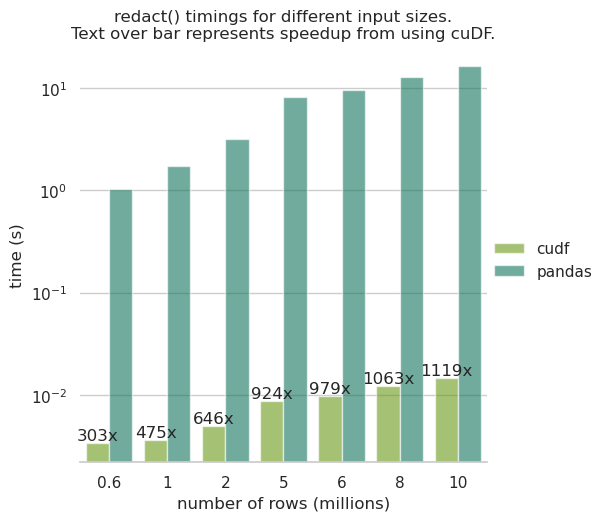

In [373]:
import matplotlib.pyplot as plt

g = sns.catplot(kind='bar', data=result, x="size", y="time", hue="lib", alpha=0.6)
g.set(yscale='log')
g.despine(left=True)
g.ax.set_yscale('log')
g.ax.set_xticklabels(["0.6", "1", "2", "5", "6", "8", "10"])
g.ax.set_xlabel('number of rows (millions)')
g.ax.set_ylabel('time (s)')
speedups = result['time'][1::2] / result['time'][0::2]
g.ax.bar_label(g.ax.containers[0], [str(int(s)) + 'x' for s in speedups])
g.legend.set_title("")
g.ax.set(title="redact() timings for different input sizes.\nText over bar represents speedup from using cuDF.")

## Example 2 - Levenshtein edit distance

Get `train.csv` [here](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction). (needs Kaggle account)

In [375]:
def leven_impl(data):
    result = np.zeros((len(data), len(data)))
    for i, s1 in enumerate(data):
        for j, s2 in enumerate(data):
            result[i, j] = levenshtein(s1, s2)
    return result

def cudf_impl(data):
    return data.str.edit_distance_matrix().list.leaves.values.reshape((len(data), len(data)))

In [376]:
train = cudf.read_csv('train.csv')
lengths = train['protein_sequence'].str.len()

# INSERTION DELETION THRESHOLD
D_THRESHOLD = 3

result = pd.DataFrame(columns=['num_strings', 'string_len', 'lib', 'time'])
sizes = []
for l in (lengths.value_counts().values_host[:10]): 
    df = train.loc[(lengths >= l-D_THRESHOLD) & (lengths <= l+D_THRESHOLD)]
    num_strings = len(df)
    print(num_strings, l)
    cudf_data = df["protein_sequence"]
    pd_data = cudf_data.to_pandas()
    cudf_result = %timeit -n 1 -r 1 -o cudf_impl(cudf_data)
    leven_result = %timeit -n 1 -r 1 -o leven_impl(pd_data)
    result = pd.concat([result, pd.DataFrame({'num_strings': [num_strings], 'string_len': [l],
                                              'lib': 'cudf', 'time': cudf_result.best})])
    result = pd.concat([result, pd.DataFrame({'num_strings': [num_strings], 'string_len': [l],
                                              'lib': 'leven', 'time': leven_result.best})])
    sizes.append(len(df))

53 856
2.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
43 828
1.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
282 370
884 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
19.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
277 274
438 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
335 250
1.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
479 245
4.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
22.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1087 232
21.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
56.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
333 224
913 ms ± 0 ns per loop (mean ± std. dev. of 

In [377]:
result['label'] = [(num_strings, string_len) for num_strings, string_len in zip(result.num_strings, result.string_len)]
mn = (result['string_len'] * result['num_strings'])
result = result.take(mn.argsort(kind='stable'))
#result = result.take(result['num_strings'] * result)

  num_strings string_len    lib       time        label
0          43        828   cudf   1.786900    (43, 828)
0          43        828  leven   2.203610    (43, 828)
0          53        856   cudf   2.011920    (53, 856)
0          53        856  leven   3.611023    (53, 856)
0         304        193   cudf   0.321077   (304, 193)
0         304        193  leven   6.212104   (304, 193)
0         402        172   cudf   1.174863   (402, 172)
0         402        172  leven   7.474984   (402, 172)
0         333        224   cudf   0.913006   (333, 224)
0         333        224  leven   9.748208   (333, 224)
0         277        274   cudf   0.437691   (277, 274)
0         277        274  leven  10.276660   (277, 274)
0         335        250   cudf   1.161432   (335, 250)
0         335        250  leven  12.984813   (335, 250)
0         282        370   cudf   0.884004   (282, 370)
0         282        370  leven  19.127859   (282, 370)
0         479        245   cudf   4.041741   (47

/tmp/ipykernel_8318/4199581458.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  speedups = result['time'][1::2] / result['time'][0::2]


[Text(0.5, 1.0, 'Time to compute levenshtein distance for different input sizes.\nText over bar represents speedup from using cuDF.')]

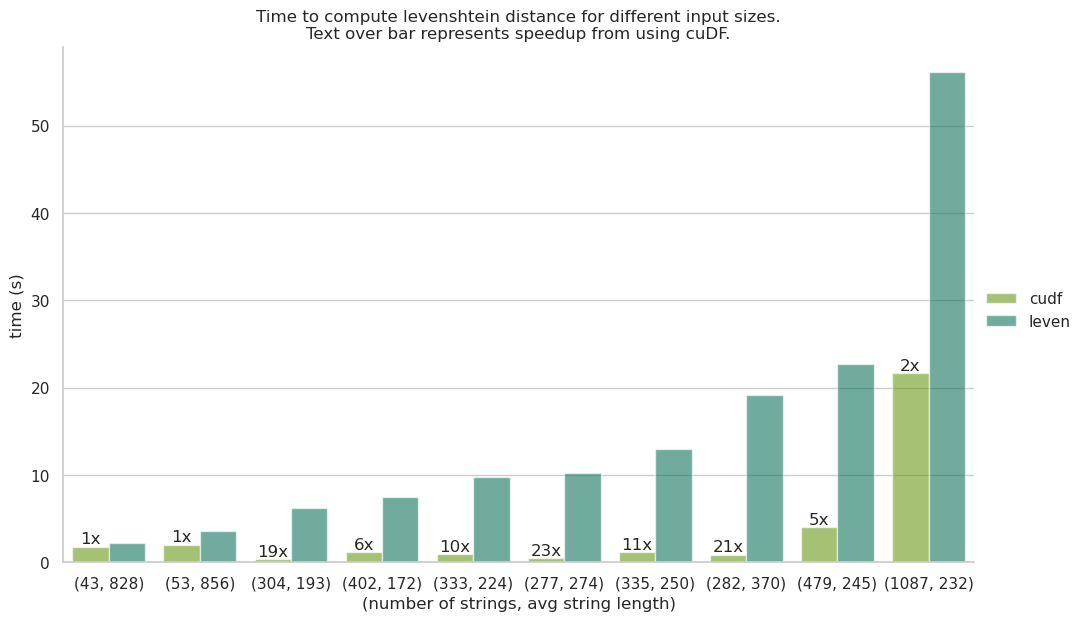

In [379]:
print(result)
g = sns.catplot(kind='bar', data=result, x="label", y="time", hue="lib", alpha=0.6, height=6, aspect=10/6)
g.ax.set_xlabel('(number of strings, avg string length)')
g.ax.set_ylabel('time (s)')
#g.set(yscale='log')

speedups = result['time'][1::2] / result['time'][0::2]
g.ax.bar_label(g.ax.containers[0], [str(int(s)) + 'x' for s in speedups])
g.legend.set_title("")
g.ax.set(title="Time to compute levenshtein distance for different input sizes.\nText over bar represents speedup from using cuDF.")

## Example 3 - user defined functions

In [15]:
import pandas as pd
import cudf

path = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz"
df = pd.read_json(path, lines=True)
df["reviewText"] = df["reviewText"].str.lower()
df["summary"] = df["summary"].str.lower()

gdf = cudf.from_pandas(df)

In [11]:
gdf.reviewText

0         this came in on time and i am veru happy with ...
1         i had a factory glock tool that i was using fo...
2         if you don't have a 3/32 punch or would like t...
3         this works no better than any 3/32 punch you w...
4         i purchased this thinking maybe i need a speci...
                                ...                        
296332    this is a water bottle done right. it is a ver...
296333    if you're looking for an insulated water bottl...
296334    this hydracentials sporty 25 oz, double insula...
296335    as usual i received this item free in exchange...
296336    hydracentials insulated 25 oz water bottle.thi...
Name: reviewText, Length: 296337, dtype: object

In [13]:
def custom_filter(row):
    return "camping" in row["reviewText"] or "camping" in row["summary"]

%timeit df[df.apply(custom_filter, axis=1)]

1.92 s ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit gdf[gdf.apply(custom_filter, axis=1)]

14.3 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
gdf[gdf.apply(custom_filter, axis=1)]["summary"]

203                                                for life
206                         excellent cheap camping air mat
218                              just like when i was a kid
438       simple and effective.  a bit large and heavy f...
451                             great nife at a great price
                                ...                        
296302                        compact and works beautifully
296306                               camping made easier...
296309            excellent dry bags...carrystraps included
296311                                 ample size and handy
296312                                 nice waterproof bags
Name: summary, Length: 10140, dtype: object